In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import altair as alt
from vega_datasets import data

# define the model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score

import plotly.express as px
import plotly.offline as py
import plotly.io as pio
import plotly.graph_objs as go 
pio.renderers.default = 'notebook_connected'
from xgboost import plot_importance
import category_encoders as ce

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import plotly.figure_factory as ff 

In [3]:
train_data=pd.read_csv('data/train_dataset.csv')
test_data=pd.read_csv('data/test_dataset.csv')

In [199]:
train_data.groupby('reordered').count()

,user_id,product_id,u_p_total,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total,p_reordered_ratio
reordered,,,,,,,,
0.0,7645837,7645837,7645837,7645837,7645837,7645837,7645837,7645837
1.0,828824,828824,828824,828824,828824,828824,828824,828824


In [200]:
train_data_1=train_data[train_data['reordered']==1]
train_data_0=train_data[train_data['reordered']==0][0:len(train_data_1)]

In [201]:
train_data= pd.concat([train_data_0,train_data_1])

In [202]:
train_data=train_data.drop(['user_id','product_id'],axis=1)
test_data=test_data.drop(['user_id','product_id'],axis=1)

### DATA PRE PROCESSING

In [203]:
train_data.columns

Index(['u_p_total', 'uxp_reorder_ratio', 'u_total_orders', 'u_reordered_ratio',
       'p_total', 'p_reordered_ratio', 'reordered'],
      dtype='object')

#### Label Encoding for categorical variables

In [204]:
#target column
target_col = ["reordered"]
#number of levels in feature to be a categorical feature
nlevels =6

#categorical columns
cat_cols = list(set(train_data.nunique()[train_data.nunique()<nlevels].keys().tolist() 
                    + train_data.select_dtypes(include='object').columns.tolist()))
cat_cols = [x for x in cat_cols if x not in target_col]

#Numerical columns
num_cols = [x for x in train_data.columns if x not in cat_cols + target_col]


#Binary columns with 2 values
#bin_cols = train_data.nunique()[train_data.nunique() == 2].keys().tolist()

#Columns more than 2 values
#multi_cols = [i for i in cat_cols if i not in bin_cols]




In [207]:
column_summary=[ 'u_p_total', 'uxp_reorder_ratio', 'u_total_orders', 'u_reordered_ratio', 'p_total', 'p_reordered_ratio', 'reordered']

#### Variable Summary

In [308]:
summary = (train_data[[i for i in column_summary]].
           describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "Feature"})
summary = np.around(summary,3)

val_lst = [summary['Feature'],summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                font= dict(color = ['white']),
                                line = dict(color = ['black']),
                                fill = dict(color = ['#DF6D28']),
                               ),
                  cells  = dict(values = val_lst,
                                font= dict(color = ['#4D4C4C']),
                                line = dict(color = ['black']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Training Variable Summary"),font= dict(color = '#4D4C4C'))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure)

#### MODELLING

In [212]:
#defining the studied or used independent features (columns) as well the target  
cols = [i for i in train_data.columns if i not in target_col]

#splitting the principal training dataset to subtrain and subtest datasets
x_train, x_test, y_train, y_test = train_test_split(train_data[cols], train_data[target_col], test_size = .25, random_state = 1696)


In [213]:
def reordering_prediction(algorithm, training_x, testing_x, training_y, testing_y, cf, threshold_plot):
    #model
    algorithm.fit(training_x, training_y)
    predictions = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
        
    print('Algorithm:', type(algorithm).__name__)
    print("Accuracy Score:", accuracy_score(testing_y, predictions))
    
    #confusion matrix
    #conf_matrix = confusion_matrix(testing_y, predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y, predictions) 
    print("Area under curve:", model_roc_auc,"\n")

### BASELINE MODEL

### Logistic Regression

In [214]:
from sklearn.linear_model import LogisticRegression

#Baseline model        
logit = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                           verbose=0, warm_start=False)

reordering_prediction(logit, x_train, x_test, y_train, y_test, "coefficients", threshold_plot=True)


Algorithm: LogisticRegression
Accuracy Score: 0.701987394187427
Area under curve: 0.7020210800596208 



In [215]:
logit.fit(x_train,y_train)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

In [244]:
coefficient_dict={'Features':'Estimated Coefficients'}

In [245]:
for i,name in enumerate(logit.feature_names_in_):
    coefficient_dict[name]=round(logit.coef_[0][i],4)


In [256]:
logistic_coefficients=pd.DataFrame(data=coefficient_dict,columns=coefficient_dict.keys(),index=range(1))

In [258]:
logistic_table= ff.create_table(logistic_coefficients,colorscale=[[0,'#DF6D28'],
                               [.5, '#ffffff'],
                                 [1, '#ffffff']],
                     font_colors=['#ffffff', '#4D4C4C',
                                '#4D4C4C'])
py.iplot(logistic_table)

### Decision Tree Classifier

In [259]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(max_depth = 9, random_state = 123,
                                       splitter = "best", criterion = "gini")

reordering_prediction(decision_tree, x_train, x_test, y_train, y_test, "features", threshold_plot=True)


Algorithm: DecisionTreeClassifier
Accuracy Score: 0.7399809851066089
Area under curve: 0.7399760704310269 



### Random Forest Classifier

In [260]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 100, random_state = 1696,
                             max_depth = 4, criterion = "gini")

reordering_prediction(rfc, x_train, x_test, y_train, y_test, 'features', threshold_plot=True)

Algorithm: RandomForestClassifier
Accuracy Score: 0.7374955358435566
Area under curve: 0.737497393101245 



#### XGBOOST 

In [261]:
from xgboost import XGBClassifier

xgc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                    max_depth=7, min_child_weight=1, missing=1, n_estimators=100,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)

reordering_prediction(xgc, x_train, x_test, y_train, y_test, "features", threshold_plot=True)

[21:04:16] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:04:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Algorithm: XGBClassifier
Accuracy Score: 0.7926628572531683
Area under curve: 0.7926616247156644 



### LIGHTGBM

In [262]:
from lightgbm import LGBMClassifier

lgbmc = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.5, max_depth=7, min_child_samples=20,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
                        n_jobs=-1, num_leaves=500, objective='binary', random_state=None,
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0)

reordering_prediction(lgbmc, x_train, x_test, y_train, y_test, "features", threshold_plot=True)

Algorithm: LGBMClassifier
Accuracy Score: 0.7688121965580147
Area under curve: 0.7688155202159731 



In [270]:
from sklearn.model_selection import RepeatedStratifiedKFold
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

models=[logit,decision_tree,rfc,xgc,lgbmc]

def evaluate_model(X, y, repeats,model):
	# prepare the cross-validation procedure
	results=list()
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=repeats, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	print('Algorithm:', type(model).__name__)
	print('>%d mean=%.4f std=%.3f' % (repeats, np.mean(scores), np.std(scores)))
	# store
	results.append(scores)
	return results

In [77]:
# for model in models:
#     evaluate_model(x_train,y_train,3,model)

#### Comparing Models

In [271]:
model_comparison = {'Logistic (Baseline)': [logit, cols],

          'Decision Tree': [decision_tree, cols], 
          
          'Random Forest': [rfc, cols], 
          
          'LGBM Classifier': [lgbmc, cols], 
          'XGBoost Classifier': [xgc, cols], 
          
         }


In [272]:
#gives model report in dataframe
def model_report(model, training_x, testing_x, training_y, testing_y, name):
    model = model.fit(training_x, training_y)
    predictions = model.predict(testing_x)
    accuracy = accuracy_score(testing_y, predictions)
    recallscore = recall_score(testing_y, predictions)
    precision = precision_score(testing_y, predictions)
    roc_auc = roc_auc_score(testing_y, predictions)
    f1score = f1_score(testing_y, predictions) 
    kappa_metric = cohen_kappa_score(testing_y, predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy"        : [accuracy],
                       "Recall"          : [recallscore],
                       "Precision"       : [precision],
                       "F1-Score"        : [f1score],
                       "ROC_AUC"         : [roc_auc],
                       "Kappa_Metric"    : [kappa_metric],
                      })
    return df

In [266]:
#outputs for all models over the training dataset
model_performances_train = pd.DataFrame() 
for name in model_comparison:
        model_performances_train = model_performances_train.append(model_report(model_comparison[name][0], x_train[model_comparison[name][1]], 
                                                                                x_test[model_comparison[name][1]], 
                                                                                y_train, y_test, name), ignore_index=True)
        

[21:10:25] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:10:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### STACKING MODELS

In [273]:
from sklearn.ensemble import StackingClassifier
# get a stacking ensemble of models
def get_stacking():
	# define the base models
    level0 = list()
    level0.append(('Logistic', logit))
    level0.append(('Decision Tree', decision_tree))
    level0.append(('Random Forest', rfc))
    level0.append(('LGBM Classifier', lgbmc))
    level0.append(('XGBoost Classifier', xgc))

    level1 = lgbmc

    stack_model=StackingClassifier(estimators=level0, final_estimator=level1)
    return stack_model

In [274]:
def base_models():
  models = dict()
  models["Logistic"] = logit
  models["Decision Tree"] = decision_tree
  models["Random Forest"] = rfc
  models['LGBM Classifier'] = lgbmc
  models['XGBoost Classifier']=xgc
  models["Stacked Model"] = get_stacking()
  return models

In [275]:
from joblib import dump, load
dump(models, "stacked-models.joblib")

['stacked-models.joblib']

In [276]:
level0 = list()
level0.append(('Logistic', logit))
level0.append(('Decision Tree', decision_tree))
level0.append(('Random Forest', rfc))
level0.append(('LGBM Classifier', lgbmc))
level0.append(('XGBoost Classifier', xgc))

level1 = lgbmc

stack_model=StackingClassifier(estimators=level0, final_estimator=level1)
stack_model.fit(x_train, y_train)

[21:20:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:20:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:41] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:32:43] WARNING: ../src/learner

StackingClassifier(estimators=[('Logistic',
                                LogisticRegression(multi_class='ovr', n_jobs=1,
                                                   solver='liblinear')),
                               ('Decision Tree',
                                DecisionTreeClassifier(max_depth=9,
                                                       random_state=123)),
                               ('Random Forest',
                                RandomForestClassifier(max_depth=4,
                                                       random_state=1696)),
                               ('LGBM Classifier',
                                LGBMClassifier(learning_rate=0.5, max_depth=7,
                                               num_leaves=500,
                                               objective='binary')),...
                                              min_child_weight=1, missing=1,
                                              monotone_constraints='()',
   

In [277]:
import pickle

# Save to file in the current working directory
pkl_filename = "StackedPickle.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(stack_model, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_stacked_model = pickle.load(file)

In [278]:
predictions = pickle_stacked_model.predict(x_test)
accuracy = accuracy_score(y_test, predictions)
recallscore = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
f1score = f1_score(y_test, predictions) 
kappa_metric = cohen_kappa_score(y_test, predictions)
    
stacked_df = pd.DataFrame({"Model"           : ['Stacked Model'],
                       "Accuracy"        : [accuracy],
                       "Recall"          : [recallscore],
                       "Precision"       : [precision],
                       "F1-Score"        : [f1score],
                       "ROC_AUC"         : [roc_auc],
                       "Kappa_Metric"    : [kappa_metric],
                      })

In [279]:
model_performances_train=model_performances_train.append(stacked_df)

In [287]:
table_train = ff.create_table(np.round(model_performances_train, 4),colorscale=[[0, '#DF6D28'],
                               [.5, '#ffffff'],
                                 [1, '#ffffff']],
                     font_colors=['#ffffff', '#4D4C4C',
                                '#4D4C4C'])
py.iplot(table_train)

In [305]:
import itertools
import math
def rocplot(modeldict, df_train, df_test, target_train, target_test, figcolnumber):
    fig = plt.figure(figsize=(4*figcolnumber, 4*math.ceil(len(modeldict)/figcolnumber)))
    fig.set_facecolor("#EFFDED")
    for name, figpos in itertools.zip_longest(modeldict, range(len(modeldict))):
        qx = plt.subplot(math.ceil(len(modeldict)/figcolnumber), figcolnumber, figpos+1)
        #model = modeldict[name][0].fit(df_train, target_train)
        probabilities = modeldict[name][0].predict_proba(df_test)
        predictions = modeldict[name][0].predict(df_test)
                        
        fpr, tpr, thresholds = roc_curve(target_test, probabilities[:,1])
        plt.plot(fpr, tpr, linestyle = "dotted",
                     color = "#9e1208", linewidth = 2,
                     label = "AUC = " + str(np.around(roc_auc_score(target_test, predictions), 3)))
        plt.plot([0,1],[0,1], linestyle = "dashed",
                     color = "black", linewidth = 1.5)
        plt.fill_between(fpr, tpr, alpha = .1,color = "#EFFDED")
        plt.fill_between([0, 1], [0, 1], color = '#DF6D28')
        plt.legend(loc = "lower right",
                       prop = {"size" : 12})
        qx.set_facecolor("w")
        
        plt.grid(False)
        
        plt.title(name, color = "#4D4C4C")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.xticks(np.arange(0, 1, .3))
        plt.yticks(np.arange(0, 1, .3))

In [289]:
stackedModel=dict()
stackedModel['Stacked Model']=[pickle_stacked_model, cols]

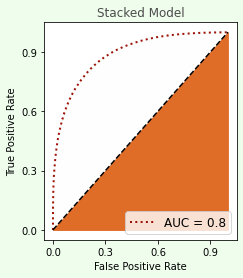

In [306]:
rocplot(modeldict=stackedModel, df_train=x_train, df_test=x_test, 
             target_train=y_train, target_test=y_test, figcolnumber=5)


In [284]:
model_comparison = {'Logistic (Baseline)': [logit, cols],

          'Decision Tree': [decision_tree, cols], 
          
          'Random Forest': [rfc, cols], 
          
          'LGBM Classifier': [lgbmc, cols], 
          'XGBoost Classifier': [xgc, cols], 
          
         }

In [301]:
from plotly.subplots import make_subplots
custom_palette = ["#EFFDED",'#FD6609']
fig2 = make_subplots(rows=1, cols=3,subplot_titles=("Random", "LightGBM", "XGBoost"))

model_updates=[rfc,lgbmc,xgc]
row=1
column=1
for model in model_updates:
        
        coefficients = pd.DataFrame(model.feature_importances_)
        
        column_df = pd.DataFrame(train_data.columns.tolist())
        coef_sumry = (pd.merge(coefficients, column_df, left_index=True, 
                               right_index=True, how="left"))
        coef_sumry.columns = ["coefficients", "features"]
        coef_sumry = coef_sumry.sort_values(by = "coefficients", ascending=False)
        
        #plot coeffs
        fig2.add_trace(go.Bar(x = coef_sumry["features"], y = coef_sumry["coefficients"], 
                        name = "coefficients",
                        marker = dict(color = coef_sumry["coefficients"],
                                      colorscale = custom_palette,
                                      line = dict(width = .6, color = "black")
                                     )
                       ),
                       row=row, col=column
                       )
        
        column+=1

        
fig2=fig2.update_layout(
    autosize=False,
    height=500,
    width=1400,
    showlegend=False,
    
    title=("Feature Importance"),
    title_font_family="Times New Roman",
    title_font_color='#4D4C4C',
    title_font_size=22,
    paper_bgcolor='White',
    plot_bgcolor='White')
  

fig2.show()

In [302]:

fig3 = make_subplots(rows=1, cols=1,subplot_titles=("Stacked Classifier",))


row=1
column=1
for model in model_updates:
    #confusion matrix
    predictions = pickle_stacked_model.predict(x_test)
    conf_matrix = confusion_matrix(y_test, predictions)
    fig3.add_trace(go.Heatmap(z = conf_matrix,
                        x = ["Not Reorder", "Reorder"],
                        y = ["Not Reorder", "Reorder"],
                        showscale = False, colorscale =custom_palette,
                        name = "Confusion matrix"),
                        row=row, col=column
                        )
    #column+=1

        
fig3=fig3.update_layout(
    autosize=False,
    height=500,
    width=500,
    showlegend=False,
    
    title=("Confusion Matrix"),
    title_font_family="Times New Roman",
    title_font_color='#4D4C4C',
    title_font_size=22,
    paper_bgcolor='White',
    plot_bgcolor='White')
  

fig3.show()

In [317]:
def hello_world():
    data = test_data
    pkl_filename = "StackedPickle.pkl"
    testvalue = np.array(test_data.iloc[5]).reshape(1, -1)
    test_input = testvalue
    with open(pkl_filename, 'rb') as file:
        pickle_model = pickle.load(file)
    predict = pickle_model.predict(test_input)
    predict_as_str = str(predict)
    return predict_as_str

hello_world()

'[1.]'